# 文件分類

**Author:** 第五組  
本周課程為「文件分類」，主要使用文章轉DTM(document term matrix)的方式，將文章用不同的字詞分布表示，再利用python的sklearn套件，套用決策樹、logistic regression等方式訓練模型，以分辨不同的文件。本篇 Jupyter Notebook 將展示「中文」的文件分類，使用日旅、韓旅、航空三個版文章做示範。

## 分析目標
+ 資料內容：
    + 資料來源：ptt
    + 版別：日旅、韓旅、航空

* 分析主題：將ptt三個不同版別的文章合起來，訓練分類模型進行文件的版別分類。

* 以下為教學目標：
    1. 如何將以數字向量代表一篇文章？
        * `CountVectorizer`
        * `TfidfVectorizer`
    2. 基本的分類模型流程，包含以下三步驟：
        * 前處理 (preprocess)
        * 建模 (train model)
        * 評估與預測 (evaluation and predict)
    3. cross validation
    4. 不同分類器的效果
    5. 可解釋的可視化模型結果
    6. 預測其他時間段文章的版別

## 1. 套件說明
下面列出在本次實作過程中我們所使用到的相關套件，在這個Jupyter Notebook當中我們將會簡單的展示這些套件的使用方式，關於各個套件的進階使用請同學參照其官網的說明。
- **sklearn**: 全名為Scikit-learn，機器學習的常用建模套件，包含各種分群、分類、迴歸模型，如隨機森林、SVM或 K-means 等。
- pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。
- jieba: 結巴套件，中文斷詞套件
- seaborn: 基於 matplotlib 封裝的繪圖工具

In [1]:
import re
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jieba
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, KFold
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    RocCurveDisplay
)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

設定中文字體

Text(0.5, 1.0, '聲量圖')

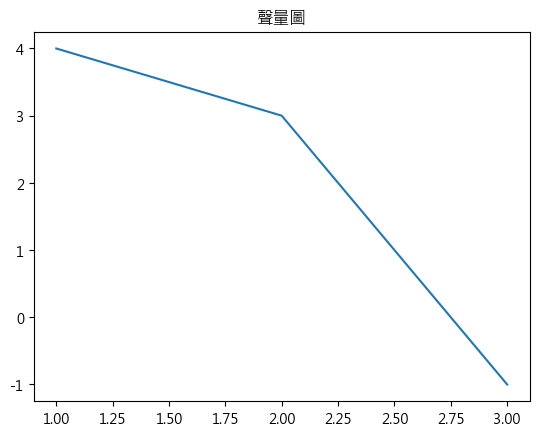

In [2]:
# https://zhuanlan.zhihu.com/p/566430362
# from matplotlib import font_manager
# font_set = {f.name for f in font_manager.fontManager.ttflist}
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus']=False
plt.plot((1, 2, 3), (4, 3, -1))
plt.title("聲量圖")

## 2. 文字前處理

- 資料來源：ptt
- 版別：日旅、韓旅、航空
- 時間範圍：2023/6/1～2023/12/31

首先我們先看文集的基本資料，並做文集前處理。

In [3]:
udn = pd.read_csv("raw_data/japan_korea_avia_train.csv")  # 匯資料
udn.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/Aviation/M.1685574818.A...,Re:[新聞]韓亞航逃生門「飛一半被打開」 空姐「肉,2023-06-01 07:13:35,cici950630,Aviation,看到這新聞想到以前的飛行體驗\n那時候從德國要去iceland hofn i\n飛丹麥轉機時...,[],209.141.52.118,2023-06-02 01:02:07,ptt
1,2,https://www.ptt.cc/bbs/Aviation/M.1685581301.A...,[分享]長榮哩程機票兌換升等後補時間,2023-06-01 09:01:39,nanna,Aviation,今天八點半準時打長榮客服，聽了很多語音，按了很多按鍵後，\n 按9轉客服，完全沒有等到。\...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""abyssa1"", ""c...",118.163.43.79,2023-06-02 01:02:07,ptt
2,3,https://www.ptt.cc/bbs/Aviation/M.1685586987.A...,[分享]紐西蘭航空貴賓室皇后鎮國內線ZQN,2023-06-01 10:36:23,Furella,Aviation,圖文網誌版:\nhttps://bitesize.tw/2018-zqn-air-new-z...,[],118.167.224.229,2023-06-02 01:02:07,ptt


In [4]:
# 看看有幾篇文章
print(f"number of posts: {udn.shape[0]}")
print(f"date range: {(udn['artDate'].min(), udn['artDate'].max())}")
print(f"category: \n{udn['artCatagory'].value_counts()}")

number of posts: 8067
date range: ('2023-06-01 00:22:53', '2023-12-31 23:30:19')
category: 
artCatagory
Japan_Travel    6063
Aviation        1059
Korea_Travel     945
Name: count, dtype: int64


+ 2.1 斷句
+ 2.2 斷詞（刪掉次數太少的、標點符號、停用字）

### 2.1 清理

* 針對column: artTitle & artContent：
    1. 過濾missing data
    2. 只留下中文字

In [5]:
# 過濾 nan 的資料
udn = udn.dropna(subset=['artTitle'])
udn = udn.dropna(subset=['artContent'])
# 移除網址格式
udn["artContent"] = udn.artContent.apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
udn["artTitle"] = udn["artTitle"].apply(
    lambda x: re.sub("(http|https)://.*", "", x)
)
# 只留下中文字
udn["artContent"] = udn.artContent.apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
udn["artTitle"] = udn["artTitle"].apply(
    lambda x: re.sub("[^\u4e00-\u9fa5]+", "", x)
)
udn.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/Aviation/M.1685574818.A...,新聞韓亞航逃生門飛一半被打開空姐肉,2023-06-01 07:13:35,cici950630,Aviation,看到這新聞想到以前的飛行體驗那時候從德國要去飛丹麥轉機時機上一女子恐慌症發作倚著艙門把拼命搖...,[],209.141.52.118,2023-06-02 01:02:07,ptt
1,2,https://www.ptt.cc/bbs/Aviation/M.1685581301.A...,分享長榮哩程機票兌換升等後補時間,2023-06-01 09:01:39,nanna,Aviation,今天八點半準時打長榮客服聽了很多語音按了很多按鍵後按轉客服完全沒有等到里程換商務艙機票兩個位...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""abyssa1"", ""c...",118.163.43.79,2023-06-02 01:02:07,ptt
2,3,https://www.ptt.cc/bbs/Aviation/M.1685586987.A...,分享紐西蘭航空貴賓室皇后鎮國內線,2023-06-01 10:36:23,Furella,Aviation,圖文網誌版年疫情前的老遊記最近發憤圖強要把全部照片圖文都整理完畢所以大量出清不喜舊遊記的朋友...,[],118.167.224.229,2023-06-02 01:02:07,ptt


文章的標題`artTitle`和內文`sentence`都會納入分析的內容，成為新的`content`欄位。

In [6]:
# 留下 content
udn["content"] = udn["artTitle"] + udn["artContent"]
udn = udn[["content", "artUrl", "artCatagory"]]  # 文章內容 文章連結
udn.head()

,content,artUrl,artCatagory
0,新聞韓亞航逃生門飛一半被打開空姐肉看到這新聞想到以前的飛行體驗那時候從德國要去飛丹麥轉機時機...,https://www.ptt.cc/bbs/Aviation/M.1685574818.A...,Aviation
1,分享長榮哩程機票兌換升等後補時間今天八點半準時打長榮客服聽了很多語音按了很多按鍵後按轉客服完...,https://www.ptt.cc/bbs/Aviation/M.1685581301.A...,Aviation
2,分享紐西蘭航空貴賓室皇后鎮國內線圖文網誌版年疫情前的老遊記最近發憤圖強要把全部照片圖文都整理...,https://www.ptt.cc/bbs/Aviation/M.1685586987.A...,Aviation
3,分享紐西蘭航空貴賓室基督城國際線圖文網誌版年疫情前的老遊記最近發憤圖強要把全部照片圖文都整理...,https://www.ptt.cc/bbs/Aviation/M.1685589145.A...,Aviation
4,問題馬印航空行李問題板上前輩好關於馬印航空的小問題想請教預計搭乘馬印航空飛在轉機機票已有附了...,https://www.ptt.cc/bbs/Aviation/M.1685590945.A...,Aviation


In [7]:
# 看看有幾篇文章
print(f"total docs: {udn.shape[0]}")


total docs: 8063


### 2.2 斷詞

<font color=#ffa>斷詞的部分加上Bigram高頻率詞彙</font>

In [8]:
# 設定繁體中文詞庫
jieba.set_dictionary("./dict/dict.txt.big")
jieba.load_userdict('./dict/travel_lexicon.txt')
# 新增stopwords
# jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open("./dict/stop_words.txt", encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

Building prefix dict from c:\Users\ariel\SMA_2024S\week7\dict\dict.txt.big ...
Loading model from cache C:\Users\ariel\AppData\Local\Temp\jieba.u07c63026232109d53925277a1d546e38.cache
Loading model cost 1.255 seconds.
Prefix dict has been built successfully.


In [9]:
# 參數形式手動加入停用字
stopwords_manual = ["一些", "一份", "一台", "一圈", "一堆", "一定", "一家", "一人", "一天", "一小", "一大", "一帶", "一座", "一張", "一旁", "一日", "一早", "一晚", "一杯", "一條", "一次", "一段", "一種", "一起", "一趟", "一路", "一邊", "一間", "三個", "三天", "上次", "上面", "上方", "上點", "下來", "下去", "下方", "下次", "下面", "不到", "不太", "不知", "不算", "中間", "之前", "之外", "之間", "令人", "以來", "以前", "以外", "以為", "似乎", "來說", "像是", "先到", "兩個", "再次", "出現", "則是", "前方", "前面", "剛剛", "十分", "in", "XD", "一下", "一位", "一個", "一半", "一直", "一點", "下午", "不用", "主要", "之後", "今天", "今年", "今日", "他們", "以下", "以後", "來到", "入住", "內容", "出發", "分享", "前往", "包含", "包括", "可能", "吃到", "各位", "名稱", "回到", "因一", "因上", "地方", "好像", "完整", "就是", "層面", "左右", "年前", "年增", "建議", "感覺", "成為", "我們", "打打", "抵達", "持續", "指出", "提供", "搭配", "整個", "方面", "旁邊", "日期", "早上", "明天", "明年", "明日", "昨日", "是否", "晚上", "最後", "月底", "有", "有沒有", "有無", "東西", "決定", "沒", "沒有", "準備", "然後", "特別", "現在", "發現", "發生", "目前", "直接", "相關", "看到", "看看", "知道", "碰到", "維持", "聞到", "聽到", "表示", "裡面", "認為", "謝謝", "這", "這裡", "這間", "造成", "造訪", "進行", "過去", "那裡", "附近", "隔天", "離開", "需要", "顯示"]
stopWords.extend(stopwords_manual)

去除停用字 & 只保留長度>1的word

In [10]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

In [11]:
udn["words"] = udn["content"].apply(getToken).map(" ".join)
udn.head()

,content,artUrl,artCatagory,words
0,新聞韓亞航逃生門飛一半被打開空姐肉看到這新聞想到以前的飛行體驗那時候從德國要去飛丹麥轉機時機...,https://www.ptt.cc/bbs/Aviation/M.1685574818.A...,Aviation,新聞 亞航 逃生門 打開 空姐 新聞 想到 飛行 體驗 德國 丹麥 轉機 時機 女子 恐慌 ...
1,分享長榮哩程機票兌換升等後補時間今天八點半準時打長榮客服聽了很多語音按了很多按鍵後按轉客服完...,https://www.ptt.cc/bbs/Aviation/M.1685581301.A...,Aviation,長榮 哩程 機票 兌換 補時 八點半 準時 長榮 客服 語音 按鍵 按轉 客服 完全 里程 ...
2,分享紐西蘭航空貴賓室皇后鎮國內線圖文網誌版年疫情前的老遊記最近發憤圖強要把全部照片圖文都整理...,https://www.ptt.cc/bbs/Aviation/M.1685586987.A...,Aviation,紐西蘭 航空 貴賓室 皇后 國內 圖文 網誌 疫情 遊記 最近 發憤圖強 全部 照片 圖文 ...
3,分享紐西蘭航空貴賓室基督城國際線圖文網誌版年疫情前的老遊記最近發憤圖強要把全部照片圖文都整理...,https://www.ptt.cc/bbs/Aviation/M.1685589145.A...,Aviation,紐西蘭 航空 貴賓室 基督城 國際 圖文 網誌 疫情 遊記 最近 發憤圖強 全部 照片 圖文...
4,問題馬印航空行李問題板上前輩好關於馬印航空的小問題想請教預計搭乘馬印航空飛在轉機機票已有附了...,https://www.ptt.cc/bbs/Aviation/M.1685590945.A...,Aviation,問題 航空 行李 問題 板上 前輩 航空 問題 請教 預計 搭乘 航空 飛在 轉機 機票 已...


### 2.3 資料集基本檢視

檢視資料內容

In [12]:
print(f"total posts: {len(udn['artUrl'].unique())}")
print(f"category: \n{udn['artCatagory'].value_counts()}")


total posts: 8063
category: 
artCatagory
Japan_Travel    6060
Aviation        1058
Korea_Travel     945
Name: count, dtype: int64


## 3. 分類模型的訓練流程
### 3.1 根據7:3的比例切分資料集
利用 sklearn 中的 train_test_split 函數將 `raw_data` 隨機切成 7:3，設置 random_state 讓每次切分的結果一致。`y_train`和`y_test`分別為訓練資料和測試資料的預測目標。

In [13]:
data = udn
X = data["words"]
y = data["artCatagory"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)

print(X_train.head())
print(y_train.head())

7861    徵求 桃園機場 台北 共乘 徵求 類別 共乘原 性別 徵求 航桃機 台北 下車 地點 台北市...
3709    問題 環球影城 待滿 整整 實在 沒想到 一整天 環球 是連 留下 遺憾 傷感 行程 飯店 ...
2710    問題 京都 交通 行程 請益 行程 京都 第四天 移動 難波 住宿 第一天 日本 中午 預計...
2369    問題 東京 短暫 四日 人去 東京 抽到 寶可夢 門票 抽到 哭哭 請問 安排 行程 可不可...
2927    資訊 日本 兒童票 年齡 定義 給有 小朋友 日本 家長 參考 日本 眾多 交通方式 小學生...
Name: words, dtype: object
7861    Korea_Travel
3709    Japan_Travel
2710    Japan_Travel
2369    Japan_Travel
2927    Japan_Travel
Name: artCatagory, dtype: object


In [14]:
# 看一下各個資料集切分的比例，應該要一致
print(
    f"raw data percentage :\n{data['artCatagory'].value_counts(normalize=True) * 100}"
)
print(f"\ntrain percentage :\n{y_train.value_counts(normalize=True) * 100}")
print(f"\ntest percentage :\n{y_test.value_counts(normalize=True) * 100}")

raw data percentage :
artCatagory
Japan_Travel    75.158130
Aviation        13.121667
Korea_Travel    11.720203
Name: proportion, dtype: float64

train percentage :
artCatagory
Japan_Travel    75.442948
Aviation        13.058115
Korea_Travel    11.498937
Name: proportion, dtype: float64

test percentage :
artCatagory
Japan_Travel    74.493592
Aviation        13.269946
Korea_Travel    12.236461
Name: proportion, dtype: float64


### 3.2 將文章轉為 DTM

DTM(document term matrix) :
+ 將不同的文章 (document) 以文章中出現過的字詞(term)表示
    + row 是document (文件)
    + column 是字詞 (term)
    + row 內的數字是出現的字數

DTM裡面的值可以有不同的表示方法
+ (1) 依據詞頻 (classic BoW)
    + 用 `CountVectorizer()`
    + unigrams and bigrams
    + [sklearn.feature_extraction.text.CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
+ (2) 依據tfidf (advanced variant of BoW)
    + 篩選出現次數大於10的字
    + 用 `TfidfVectorizer()`
    + [sklearn.feature_extraction.text.TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
+ 常用參數介紹
    + max_features: 取 詞頻 / tfidf 前多少的字

### 3.3 套入正式的資料集
+  模型訓練範例: logistic regression + cv tokenizer

<font color=#ffa>用 Vectorizer 計算詞頻，之後篩選出現次數大於10的字詞 </font>

<font color=#ffa>這裡使用的 Train 和 Test 的資料和結果都是使用 Vectorizer 生成的 DTM，等等會與使用 TfidfVectorizer 的結果進行比較</font>

In [15]:
vectorizer = CountVectorizer(max_features=1000)
print(vectorizer)

CountVectorizer(max_features=1000)


In [16]:
X_train.head()

7861    徵求 桃園機場 台北 共乘 徵求 類別 共乘原 性別 徵求 航桃機 台北 下車 地點 台北市...
3709    問題 環球影城 待滿 整整 實在 沒想到 一整天 環球 是連 留下 遺憾 傷感 行程 飯店 ...
2710    問題 京都 交通 行程 請益 行程 京都 第四天 移動 難波 住宿 第一天 日本 中午 預計...
2369    問題 東京 短暫 四日 人去 東京 抽到 寶可夢 門票 抽到 哭哭 請問 安排 行程 可不可...
2927    資訊 日本 兒童票 年齡 定義 給有 小朋友 日本 家長 參考 日本 眾多 交通方式 小學生...
Name: words, dtype: object

In [17]:
vectorizer.fit(X_train)
vec_train = vectorizer.transform(X_train)
vec_train

<5644x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 225934 stored elements in Compressed Sparse Row format>

In [18]:
### 用 `toarray()` 轉成 numpy array
vec_train.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [19]:
# 可用 `fit_transform()` 一次完成
vec_train = vectorizer.fit_transform(X_train)
print(vectorizer.get_feature_names_out()[:10])


['一整天' '一日遊' '一樓' '一班' '一站' '一點點' '三井' '上午' '上山' '上網']


In [20]:
# fit 完後，可以用 `vocabulary_` 看到詞的 feature index
print(vectorizer.vocabulary_)
vectorizer.vocabulary_['一日遊']

{'徵求': 361, '桃園機場': 513, '台北': 181, '類別': 962, '性別': 366, '下車': 13, '地點': 238, '地址': 235, '金額': 907, '備註': 80, '內信': 97, '問題': 211, '環球影城': 623, '實在': 295, '沒想到': 557, '一整天': 0, '環球': 622, '行程': 767, '飯店': 974, '時間': 465, '紀錄': 693, '這次': 861, '還沒': 890, '去過': 166, '是從': 462, '訂票': 788, '官網': 283, '導致': 301, '無法': 592, '選擇': 885, '希望': 327, '自行': 740, '重要': 904, '原本': 163, '大阪': 259, '梅田': 515, '真的': 652, '報到': 241, '現場': 618, '任天堂': 58, '單人': 214, '參加': 167, '小時': 307, '分鐘': 129, '上車': 10, '組合': 697, '參觀': 170, '氣氛': 552, '工作人員': 321, '等於': 684, '考慮': 728, '排隊': 398, '根本': 511, '辦法': 849, '關係': 926, '變成': 808, '應該': 378, '只能': 178, '放棄': 421, '哈利波': 204, '解決': 784, '所有': 387, '方式': 436, '值得': 73, '簡單': 688, '奈良': 267, '拍照': 394, '回來': 219, '喜歡': 213, '方案': 437, '提早': 407, '入園': 94, '整理': 423, '京都': 43, '交通': 38, '請益': 806, '第四天': 682, '移動': 667, '難波': 940, '住宿': 65, '第一天': 678, '日本': 450, '中午': 21, '預計': 958, '民宿': 550, '確定': 655, '改成': 419, '市場': 326, '第二天': 681, '有點': 488, '詢問': 800

1

In [21]:
# 不需重新 `fit()` data，因前面已經 `fit()` 過了
# 只需將測試數據使用之前訓練好的 vectorizer 轉換為相同的特徵表示形式，而不需要重新fit。
# 如果對測試數據再次 fit vectorizer，可能會導致使用了測試數據的信息，進而導致模型的不穩定性和過度擬合的問題。
vec_test = vectorizer.transform(X_test)
print(vec_train.shape)
print(vec_test.shape)

(5644, 1000)
(2419, 1000)


<font color=#ffa>以 Logistic Regression 建立模型並預測類別，之後使用 Confusion Matrix 查看預測的結果</font>


In [22]:
# 建立分類器模型
clf = LogisticRegression()
clf.fit(vec_train, y_train)
clf

c:\Users\ariel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [23]:
clf.classes_

array(['Aviation', 'Japan_Travel', 'Korea_Travel'], dtype=object)

In [24]:
y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)
print(y_pred[:10])

['Japan_Travel' 'Korea_Travel' 'Japan_Travel' 'Korea_Travel'
 'Korea_Travel' 'Japan_Travel' 'Japan_Travel' 'Japan_Travel'
 'Japan_Travel' 'Japan_Travel']


In [25]:
print(y_pred_proba.shape)
y_pred_proba[0,:]

(2419, 3)


array([2.98419821e-16, 9.99999995e-01, 5.32013783e-09])

<font color=#ffa>這裡結果都是使用 Vectorizer 的，等等會與使用 TfidfVectorizer 的結果進行比較</font>

In [26]:
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Aviation       0.88      0.81      0.84       321
Japan_Travel       0.95      0.98      0.96      1802
Korea_Travel       0.93      0.84      0.88       296

    accuracy                           0.94      2419
   macro avg       0.92      0.87      0.90      2419
weighted avg       0.94      0.94      0.94      2419



In [27]:
classes = clf.classes_
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 259,   57,    5],
       [  24, 1765,   13],
       [  11,   37,  248]], dtype=int64)

(array([0.5, 1.5, 2.5]),
 [Text(0, 0.5, 'Aviation'),
  Text(0, 1.5, 'Japan_Travel'),
  Text(0, 2.5, 'Korea_Travel')])

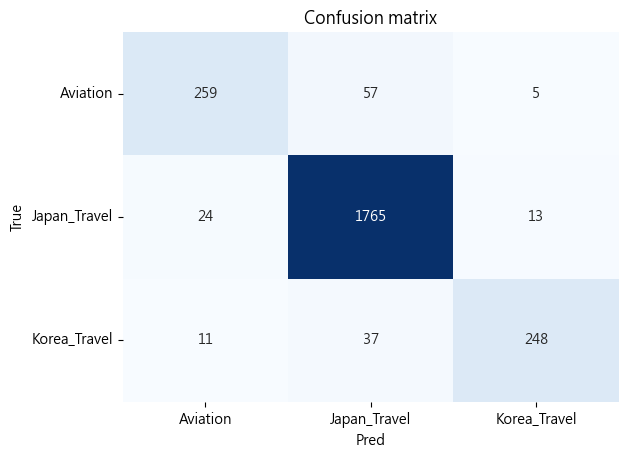

In [28]:
## Plot confusion matrix
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(
    xlabel="Pred",
    ylabel="True",
    xticklabels=classes,
    yticklabels=classes,
    title="Confusion matrix",
)
plt.yticks(rotation=0)

### 3.4 tfidf

改試試看使用 tf-idf 的 DTM 來代表文章，訓練分類模型的效果

<font color=#ffa>這裡使用 TfidfVectorizer 生成 DTM</font>

In [29]:
vectorizer = TfidfVectorizer(max_features=1000)
vec_train = vectorizer.fit_transform(X_train)
vec_test = vectorizer.transform(X_test)
vec_train.toarray()[0,:]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.23765497, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [30]:
clf.fit(vec_train, y_train)
y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)

# results
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Aviation       0.91      0.79      0.85       321
Japan_Travel       0.94      0.99      0.96      1802
Korea_Travel       1.00      0.77      0.87       296

    accuracy                           0.94      2419
   macro avg       0.95      0.85      0.89      2419
weighted avg       0.94      0.94      0.94      2419



<font style="font-size: 20px;">Logistic regression 結果比較： 詞頻 v.s. tf-idf</font>

<font color=#ffa>可以看到使用 TfidfVectorizer 和使用 Vectorizer 的結果差不多，但 Aviation 類別在使用 TfidfVectorizer 時的效果較佳</font>


### 3.5 CV

接著介紹 cross-validation。CV 在機器學習中，是一個很常用來讓模型評估能夠得到更穩定的數值的手法。

* figure1: 

<img src="https://scikit-learn.org/stable/_images/grid_search_workflow.png"  width="1000">

* figure 2:  

![](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

source: <https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-and-model-selection>

cross-validation 會自動切成 k 組 train-test dataset。  
`cross_validate()` 會回傳經過 cross-validation 的模型評估結果。

<font color=#ffa>這邊將 CV 應用在 LogisticRegression 中 (但結果沒有比較好，猜測可能是因為類別不平均問題)</font>

In [31]:
clf = LogisticRegression()
vec_train = TfidfVectorizer(max_features=1000).fit_transform(X_train)

scores = cross_validate(clf, vec_train, y_train, cv=5, scoring=("f1_macro", "recall_macro", "precision_macro"), return_estimator=True)
pprint(scores)

{'estimator': [LogisticRegression(),
               LogisticRegression(),
               LogisticRegression(),
               LogisticRegression(),
               LogisticRegression()],
 'fit_time': array([0.16117215, 0.13797569, 0.11518097, 0.12306118, 0.14387822]),
 'score_time': array([0.02007413, 0.01996255, 0.01699901, 0.01688337, 0.01498985]),
 'test_f1_macro': array([0.88206678, 0.8993769 , 0.84883964, 0.87951225, 0.89044434]),
 'test_precision_macro': array([0.9257428 , 0.94090756, 0.91801218, 0.92481436, 0.93412997]),
 'test_recall_macro': array([0.84741194, 0.86633501, 0.79931604, 0.84543071, 0.85609523])}


`cross_val_predict()` 則會回傳 cv 預測的類別。

In [32]:
y_pred = cross_val_predict(clf, vec_train, y_train, cv=5)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

    Aviation       0.88      0.79      0.83       737
Japan_Travel       0.94      0.98      0.96      4258
Korea_Travel       0.97      0.76      0.85       649

    accuracy                           0.93      5644
   macro avg       0.93      0.84      0.88      5644
weighted avg       0.93      0.93      0.93      5644



## 4. 比較不同模型效果

<font color=#ffa>這邊使用 TfidfVectorizer 生成的 DTM 來 Train 四種模型，且全部都有加上 CV</font>

<font color=#ffa>四種模型分別是 Logistic, Decision tree, SVM, Random forest</font>

In [33]:
# 定義模型訓練組合
## pipeline: 資料處理 vectorizer + 分類器 clf
## 由於 cross-validation 會自動將資料分成 train/test，因此 input 只要給 X, y 即可

def train_cv(vectorizer, clf, X, y):

    ## train classifier
    vec_X = vectorizer.fit_transform(X).toarray()
    
    ## get cv results
    cv_results = cross_validate(clf, vec_X, y, cv=5, return_estimator=True)
    y_pred = cross_val_predict(clf, vec_X, y, cv=5)
    y_pred_proba = cross_val_predict(clf, vec_X, y, cv=5, method="predict_proba")

    ## Accuracy, Precision, Recall, F1-score
    cls_report = classification_report(y, y_pred, output_dict=True)
    print(classification_report(y, y_pred))

    classes = cv_results['estimator'][0].classes_
    
    ## Plot confusion matrix
    cm = confusion_matrix(y, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(
        xlabel="Pred",
        ylabel="True",
        xticklabels=classes,
        yticklabels=classes,
        title= str(clf) + "Confusion matrix",
    )
    plt.yticks(rotation=0)

    clf.fit(vec_X, y)
    # return the model object
    return cls_report

              precision    recall  f1-score   support

    Aviation       0.88      0.79      0.83       737
Japan_Travel       0.94      0.98      0.96      4258
Korea_Travel       0.97      0.76      0.85       649

    accuracy                           0.93      5644
   macro avg       0.93      0.84      0.88      5644
weighted avg       0.93      0.93      0.93      5644



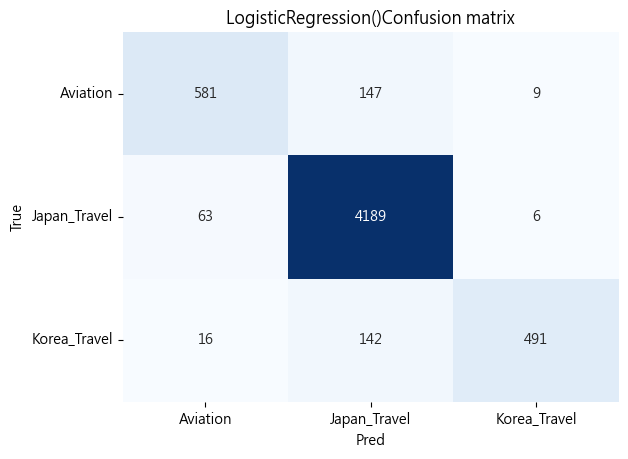

In [34]:
vectorizer = TfidfVectorizer(max_features=1000)
clf = LogisticRegression()
result = train_cv(vectorizer, clf, X_train, y_train)

now training: clf_logistic
              precision    recall  f1-score   support

    Aviation       0.88      0.79      0.83       737
Japan_Travel       0.94      0.98      0.96      4258
Korea_Travel       0.97      0.76      0.85       649

    accuracy                           0.93      5644
   macro avg       0.93      0.84      0.88      5644
weighted avg       0.93      0.93      0.93      5644

now training: clf_dtree
              precision    recall  f1-score   support

    Aviation       0.75      0.75      0.75       737
Japan_Travel       0.94      0.94      0.94      4258
Korea_Travel       0.82      0.81      0.81       649

    accuracy                           0.90      5644
   macro avg       0.84      0.84      0.84      5644
weighted avg       0.90      0.90      0.90      5644

now training: clf_svm
              precision    recall  f1-score   support

    Aviation       0.89      0.79      0.84       737
Japan_Travel       0.94      0.98      0.96      4258
Ko

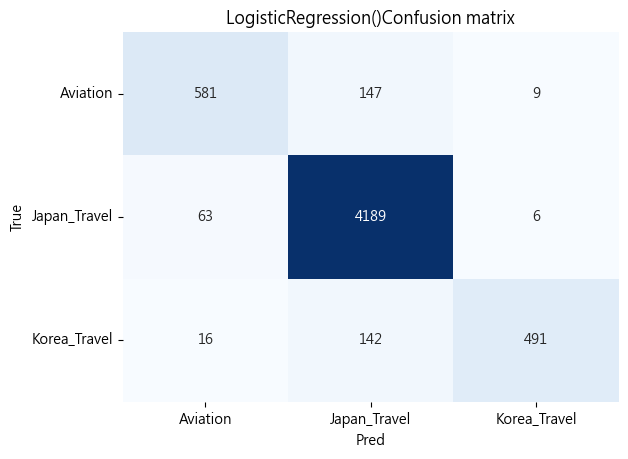

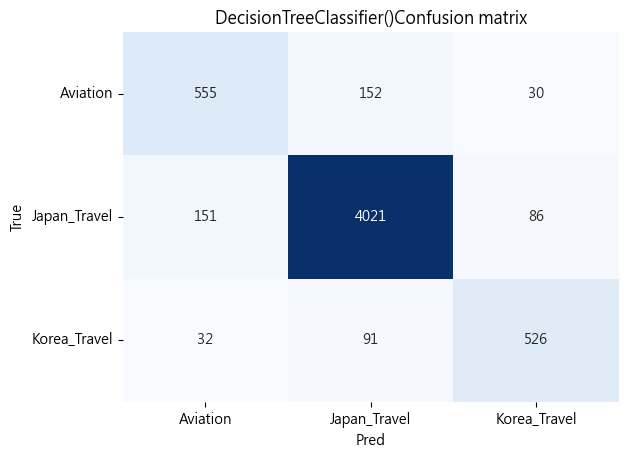

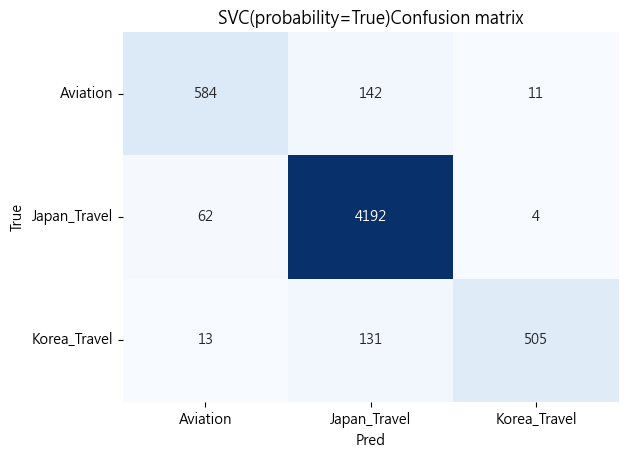

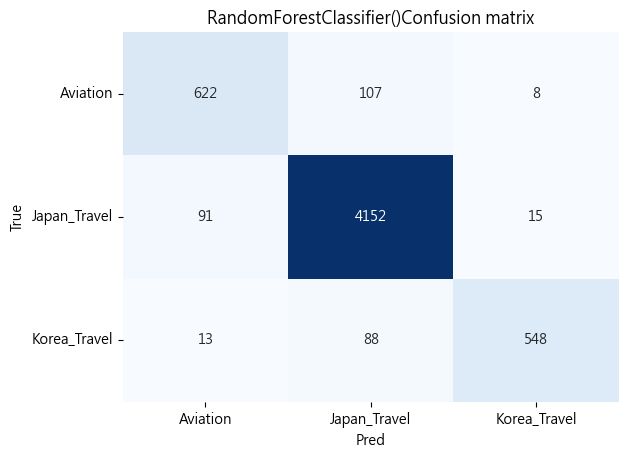

In [35]:
# 準備訓練資料
X = data["words"]
y = data["artCatagory"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)
# 定義模型訓練組合
model_set = dict()
model_set['clf_logistic'] = LogisticRegression()
model_set['clf_dtree'] = DecisionTreeClassifier()
model_set['clf_svm'] = svm.SVC(probability=True) # 要使用SVM的predict_proba的話，必須在叫出SVC的時候就將probability設為True
model_set['clf_rf'] = RandomForestClassifier()
# 定義 vectorizer
# vectorizer = CountVectorizer(max_features=1000)
vectorizer = TfidfVectorizer(max_features=1000)
# 存結果
result_set = dict()

for k, model in model_set.items():
    print("="*100)
    print(f"now training: {k}")
    result_set[k] = train_cv(vectorizer, model, X_train, y_train)
    print("="*100)


In [36]:
#clf_logistic, clf_dtree, clf_svm, clf_rf
result_set['clf_logistic']

{'Aviation': {'precision': 0.8803030303030303,
  'recall': 0.7883310719131614,
  'f1-score': 0.8317823908375089,
  'support': 737.0},
 'Japan_Travel': {'precision': 0.9354622599374721,
  'recall': 0.9837952090183184,
  'f1-score': 0.9590201465201464,
  'support': 4258.0},
 'Korea_Travel': {'precision': 0.9703557312252964,
  'recall': 0.7565485362095532,
  'f1-score': 0.8502164502164502,
  'support': 649.0},
 'accuracy': 0.932140326009922,
 'macro avg': {'precision': 0.9287070071552662,
  'recall': 0.8428916057136777,
  'f1-score': 0.880339662524702,
  'support': 5644.0},
 'weighted avg': {'precision': 0.9322718826563264,
  'recall': 0.932140326009922,
  'f1-score': 0.9298940258895295,
  'support': 5644.0}}

<font color=#ffa>Print 出最佳的模型結果 - Random Forest</font>

In [37]:
max = 0
best_model_name = ""
best_model_metric = "f1-score"

## choose max f1-score model from result_set
for k, v in result_set.items():
    if v['weighted avg'][best_model_metric] > max:
        max = v['weighted avg'][best_model_metric]
        best_model_name = k
print(f"best model: {best_model_name}")
pprint(result_set[best_model_name])

best model: clf_rf
{'Aviation': {'f1-score': 0.8503075871496923,
              'precision': 0.8567493112947658,
              'recall': 0.8439620081411127,
              'support': 737.0},
 'Japan_Travel': {'f1-score': 0.9650203370133643,
                  'precision': 0.9551414768806074,
                  'recall': 0.9751056834194457,
                  'support': 4258.0},
 'Korea_Travel': {'f1-score': 0.8983606557377048,
                  'precision': 0.9597197898423818,
                  'recall': 0.8443759630200308,
                  'support': 649.0},
 'accuracy': 0.9429482636428065,
 'macro avg': {'f1-score': 0.9045628599669205,
               'precision': 0.923870192672585,
               'recall': 0.8878145515268631,
               'support': 5644.0},
 'weighted avg': {'f1-score': 0.9423758597282067,
                  'precision': 0.9428197722518735,
                  'recall': 0.9429482636428065,
                  'support': 5644.0}}


In [38]:
y_pred = model_set['clf_rf'].predict(vectorizer.transform(X_test).toarray())
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Aviation       0.91      0.86      0.88       321
Japan_Travel       0.95      0.99      0.97      1802
Korea_Travel       0.99      0.83      0.90       296

    accuracy                           0.95      2419
   macro avg       0.95      0.89      0.92      2419
weighted avg       0.95      0.95      0.95      2419



<font color=#ffa>最佳的 model 為 Random Forest，其中 Decision Tree 的表現較差外，其餘三個 model （Logistic、SVM、Random Forest）表現差不多</font>

<font color=#ffa>嘗試使用 Vectorizer，與 TfidfVectorizer 比較後，發現結果差不多，最佳的模型依舊是 Random Forest</font>

c:\Users\ariel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\ariel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

              precision    recall  f1-score   support

    Aviation       0.86      0.82      0.84       737
Japan_Travel       0.95      0.97      0.96      4258
Korea_Travel       0.90      0.84      0.87       649

    accuracy                           0.94      5644
   macro avg       0.91      0.88      0.89      5644
weighted avg       0.94      0.94      0.94      5644



c:\Users\ariel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


now training: clf_logistic
              precision    recall  f1-score   support

    Aviation       0.88      0.79      0.83       737
Japan_Travel       0.94      0.98      0.96      4258
Korea_Travel       0.97      0.76      0.85       649

    accuracy                           0.93      5644
   macro avg       0.93      0.84      0.88      5644
weighted avg       0.93      0.93      0.93      5644

now training: clf_dtree
              precision    recall  f1-score   support

    Aviation       0.75      0.74      0.75       737
Japan_Travel       0.94      0.95      0.94      4258
Korea_Travel       0.81      0.81      0.81       649

    accuracy                           0.90      5644
   macro avg       0.84      0.83      0.83      5644
weighted avg       0.90      0.90      0.90      5644

now training: clf_svm
              precision    recall  f1-score   support

    Aviation       0.89      0.79      0.84       737
Japan_Travel       0.94      0.98      0.96      4258
Ko

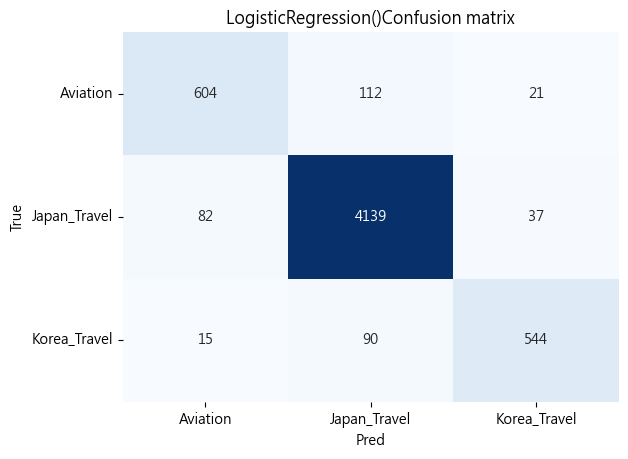

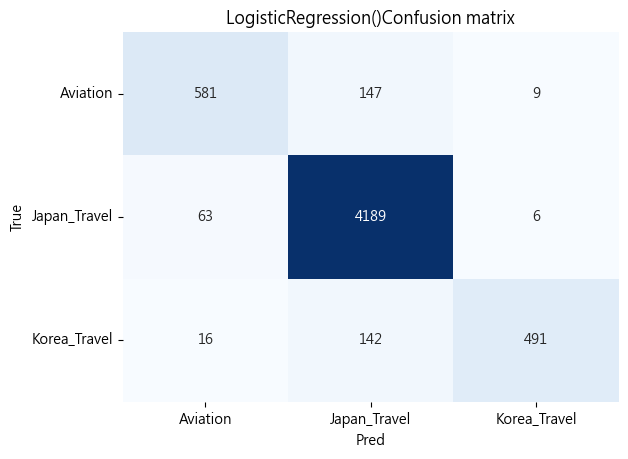

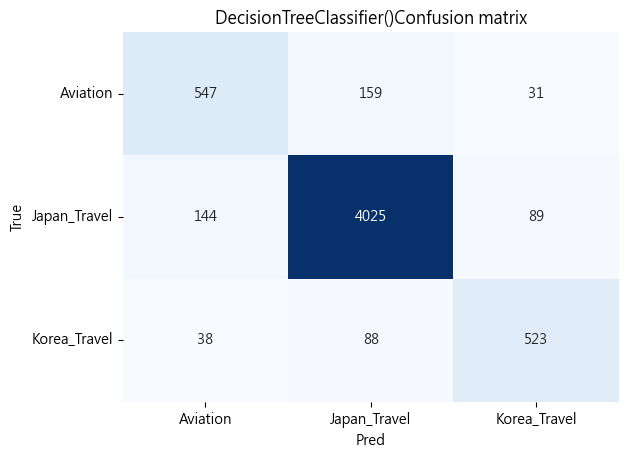

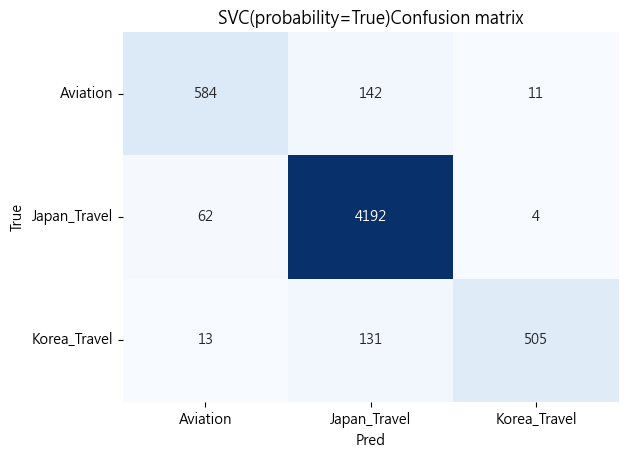

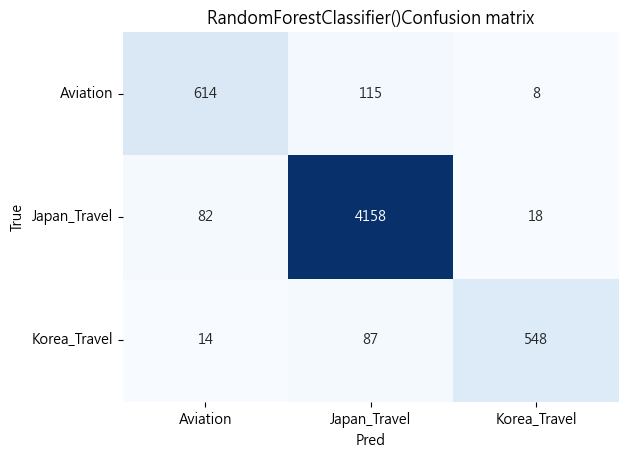

In [39]:
vectorizer = CountVectorizer(max_features=1000)
clf = LogisticRegression()
result = train_cv(vectorizer, clf, X_train, y_train)

# 準備訓練資料
X = data["words"]
y = data["artCatagory"]

# 把整個資料集七三切
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)
# 定義模型訓練組合
model_set = dict()
model_set['clf_logistic'] = LogisticRegression()
model_set['clf_dtree'] = DecisionTreeClassifier()
model_set['clf_svm'] = svm.SVC(probability=True) # 要使用SVM的predict_proba的話，必須在叫出SVC的時候就將probability設為True
model_set['clf_rf'] = RandomForestClassifier()
# 定義 vectorizer
# vectorizer = CountVectorizer(max_features=1000)
vectorizer = TfidfVectorizer(max_features=1000)
# 存結果
result_set = dict()

for k, model in model_set.items():
    print("="*100)
    print(f"now training: {k}")
    result_set[k] = train_cv(vectorizer, model, X_train, y_train)
    print("="*100)


In [40]:
max = 0
best_model_name = ""
best_model_metric = "f1-score"

## choose max f1-score model from result_set
for k, v in result_set.items():
    if v['weighted avg'][best_model_metric] > max:
        max = v['weighted avg'][best_model_metric]
        best_model_name = k

print(f"best model: {best_model_name}")
y_pred = model_set['clf_rf'].predict(vectorizer.transform(X_test).toarray())
print(classification_report(y_test, y_pred))
pprint(result_set[best_model_name])


best model: clf_rf
              precision    recall  f1-score   support

    Aviation       0.90      0.87      0.88       321
Japan_Travel       0.96      0.99      0.97      1802
Korea_Travel       0.98      0.84      0.90       296

    accuracy                           0.95      2419
   macro avg       0.94      0.90      0.92      2419
weighted avg       0.95      0.95      0.95      2419

{'Aviation': {'f1-score': 0.8486523842432618,
              'precision': 0.8647887323943662,
              'recall': 0.8331071913161465,
              'support': 737.0},
 'Japan_Travel': {'f1-score': 0.9649570666047806,
                  'precision': 0.9536697247706422,
                  'recall': 0.9765147956787225,
                  'support': 4258.0},
 'Korea_Travel': {'f1-score': 0.8961569910057237,
                  'precision': 0.9547038327526133,
                  'recall': 0.8443759630200308,
                  'support': 649.0},
 'accuracy': 0.9425939050318922,
 'macro avg': {'f1-score

## 5. 分析可解釋模型的結果

### 5.1 各字詞特徵的estimate係數
對於線性的模型，可以藉由相關係數，查看資料特徵（詞）對於判斷分類的影響
+ coefficient estimate 代表特徵每增加一單位（在此處會是該文章的某字詞頻 +1），y是1的發生機率比y是0的發生機率多幾倍（odds ratio 勝算比）
+ 這裡舉logistic regression + cv tokenizer 為例

In [41]:
def plot_coef(logistic_reg_model, feature_names, top_n=10):
    # 選出某個類別的前10大影響力字詞
    log_odds = logistic_reg_model.coef_.T
    coef_df = pd.DataFrame(
        log_odds, 
        columns=logistic_reg_model.classes_, index=feature_names
    )
    for label in coef_df.columns:
        select_words = (
            coef_df[[label]]
            .sort_values(by=label, ascending=False)
            .iloc[np.r_[0:top_n, -top_n:0]]
        )
        word = select_words.index
        count = select_words[label]
        category_colors = np.where(
            select_words[label] >= 0, "darkseagreen", "rosybrown"
        )  # 設定顏色

        fig, ax = plt.subplots(figsize=(8, top_n*0.8))  # 設定畫布
        plt.rcParams["axes.unicode_minus"] = False

        ax.barh(word, count, color=category_colors)
        ax.invert_yaxis()
        ax.set_title(
            "Coeff increase/decrease odds ratio of 「" + label + "」 label the most",
            loc="left",
            size=16,
        )
        ax.set_ylabel("word", size=14)
        ax.set_xlabel("odds ratio", size=14)

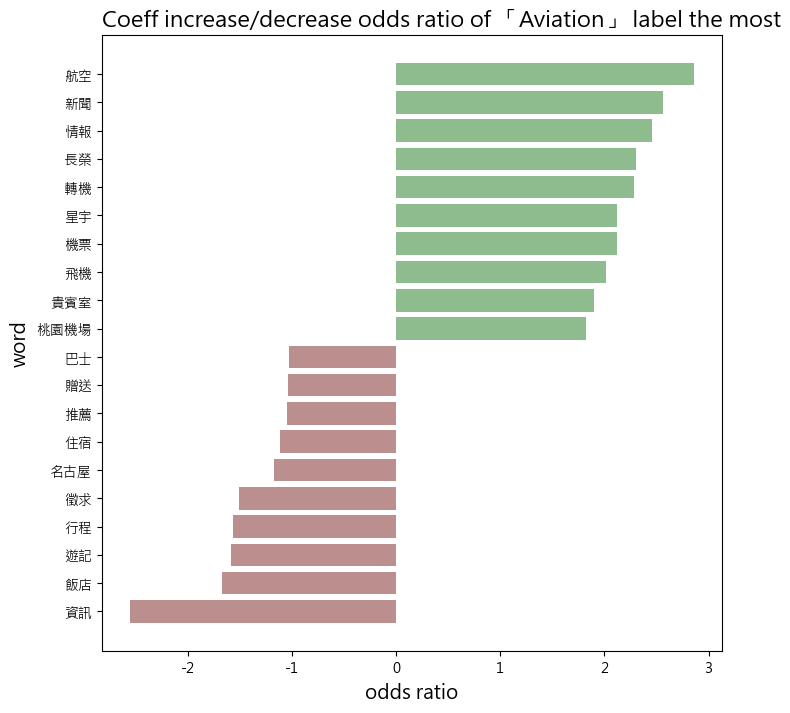

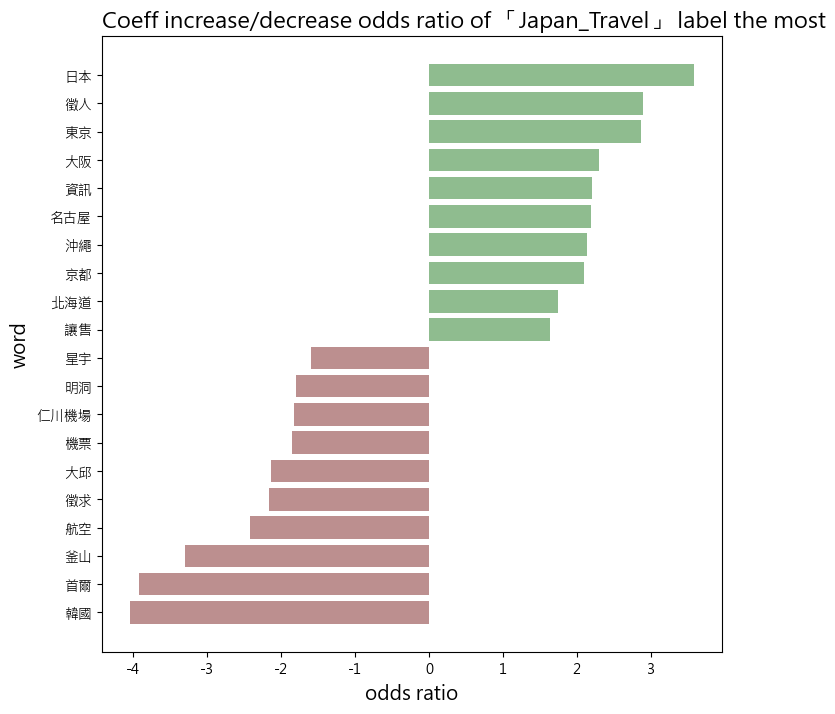

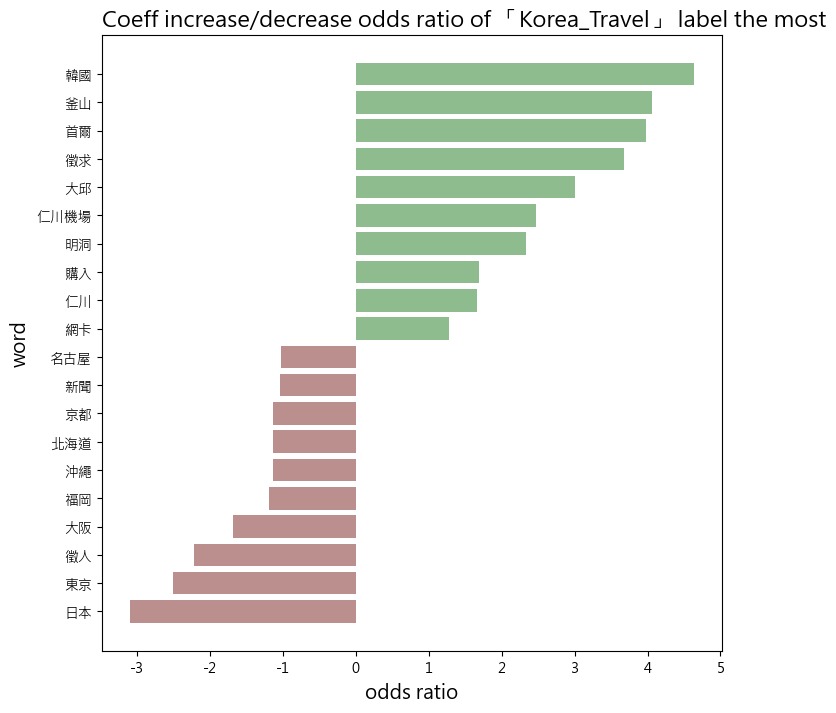

In [42]:
plot_coef(logistic_reg_model=model_set['clf_logistic'], feature_names=vectorizer.get_feature_names_out(), top_n=10)


<font color=#ffa>「航空」中出現了轉機、機票、新聞、長榮、桃園機場、星宇等，航空相關關鍵字；
「日旅」中高係數的字多是日本旅遊地點，像是東京，大阪、名古屋...；
「韓旅」中高係數的字多是韓國旅遊地點，像是釜山，首爾、大邱、仁川機場...。
<br>可以發現其中有根據Bigram斷詞的結果，例如：桃園機場、仁川機場等。</font>

## 6. 預測ptt文章類別

- 版別：日旅、韓旅、航空
- 時間範圍：2024/1/1～2024/3/31

In [43]:
ct = pd.read_csv("./raw_data/japan_korea_avia_test.csv")
ct.dropna(inplace=True)
ct

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/Aviation/M.1704099792.A...,[情報]能登半島大地震M7.6KIJ關場中,2024-01-01 17:03:09,jh961202,Aviation,以防萬一有人來這邊問，也發一篇：\n台灣時間下午3時10分，能登半島發生大地震\n（速報值M...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""yhls"", ""cmtC...",122.116.60.211,2024-01-02 01:02:12,ptt
1,2,https://www.ptt.cc/bbs/Aviation/M.1704113816.A...,[分享]20231221JX725TPE-KUL,2024-01-01 20:56:54,ATR72,Aviation,祝各位板友新年快樂！\n\n\n去年年初因為辦了玉山星宇聯名卡，所以有了3000元的折扣，\...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""ingridlyon"",...",114.37.172.131,2024-01-02 01:02:12,ptt
2,3,https://www.ptt.cc/bbs/Aviation/M.1704131645.A...,[問題]入境日本1小時後出境是否影響入境審查,2024-01-02 01:54:03,lonboo,Aviation,請教若飛到日本抵達航班時間預設為11:00\n\n但13:30又立刻飛回台灣\n\n那這樣在...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""Kifoiser"", ""...",61.228.190.207,2024-01-03 01:02:16,ptt
3,4,https://www.ptt.cc/bbs/Aviation/M.1704153162.A...,[新聞]罷工遇能登半島7.6強震捷星日本航空喊卡,2024-01-02 07:52:40,sammy98,Aviation,[媒體名稱]\nYahoo新聞 今日新聞\n國際中心蔡姍伶／綜合報導\n[新聞日期]\n20...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""tiesto06202""...",223.140.223.203,2024-01-03 01:02:16,ptt
4,5,https://www.ptt.cc/bbs/Aviation/M.1704186030.A...,[分享]羽田火災？,2024-01-02 17:00:28,sammy98,Aviation,https://www.youtube.com/live/6NLUoAmlm0A?si=kM...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""Profaner"", ""...",223.140.223.203,2024-01-03 01:02:16,ptt
...,...,...,...,...,...,...,...,...,...,...,...
3805,3806,https://www.ptt.cc/bbs/Korea_Travel/M.17118127...,[交通]「出售」臺北-首爾來回機票,2024-03-30 23:31:43,iopp50,Korea_Travel,春酒中獎機票香香價轉讓\n台北-首爾 來回機票*2\n-價格14000（已含各種稅）\n-機...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""SK3"", ""cmtCo...",114.33.91.69,2024-04-01 02:08:27,ptt
3806,3807,https://www.ptt.cc/bbs/Korea_Travel/M.17118639...,[問題]請教仁川機場到東橫inn東大門搭機場巴士,2024-03-31 13:46:01,Mollyc,Korea_Travel,想請教住過東橫inn東大門店的版友\n從仁川機場出發，是否可以搭乘6001號機場巴士直接到旅...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""ponchiyang"",...",49.158.130.17,2024-04-01 02:08:27,ptt
3807,3808,https://www.ptt.cc/bbs/Korea_Travel/M.17118657...,[問題]樂天租車會員註冊無法,2024-03-31 14:15:48,miaou0123,Korea_Travel,想請問，這兩天註冊樂天租車的英文版會員\n\n選擇國家taiwan，輸入email之後，收到...,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""betty0217"", ...",111.83.195.237,2024-04-01 02:08:27,ptt
3808,3809,https://www.ptt.cc/bbs/Korea_Travel/M.17118782...,[問題]關於濟州島一日券,2024-03-31 17:44:35,williamsm,Korea_Travel,由於在五月有規劃濟州島的行程\n有規劃兩天是觀光巴士（不租車）的行程\n後來一些網站上有看到...,[],39.12.88.167,2024-04-01 02:08:27,ptt


文字清理

In [44]:
# 移除網址格式
ct["artContent"].str.replace("(http|https)://.*", "", regex=True)
ct["artTitle"].str.replace("(http|https)://.*", "", regex=True)
ct["artContent"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)
ct["artTitle"].str.replace("[^\u4e00-\u9fa5]+", "", regex=True)

# 留下 content
ct["content"] = ct["artTitle"] + ct["artContent"]
ct = ct.loc[:,["content", "artUrl", "artCatagory"]]  # 文章內容 文章連結

# 設定斷詞 function
def getToken(row):
    seg_list = jieba.cut(row, cut_all=False)
    seg_list = [
        w for w in seg_list if w not in stopWords and len(w) > 1
    ]  # 篩選掉停用字與字元數大於1的詞彙
    return seg_list

ct["words"] = ct["content"].apply(getToken).map(" ".join)
ct.head()

,content,artUrl,artCatagory,words
0,[情報]能登半島大地震M7.6KIJ關場中以防萬一有人來這邊問，也發一篇：\n台灣時間下午3...,https://www.ptt.cc/bbs/Aviation/M.1704099792.A...,Aviation,情報 能登 半島 地震 M7.6 KIJ 關場 以防萬一 有人 一篇 台灣 時間 10 能登...
1,[分享]20231221JX725TPE-KUL祝各位板友新年快樂！\n\n\n去年年初因為...,https://www.ptt.cc/bbs/Aviation/M.1704113816.A...,Aviation,20231221JX725TPE KUL 板友 新年快樂 去年 年初 玉山 星宇 聯名卡 3...
2,[問題]入境日本1小時後出境是否影響入境審查請教若飛到日本抵達航班時間預設為11:00\n\...,https://www.ptt.cc/bbs/Aviation/M.1704131645.A...,Aviation,問題 入境 日本 小時 出境 影響 入境 審查 請教 若飛到 日本 航班 時間 預設 11 ...
3,[新聞]罷工遇能登半島7.6強震捷星日本航空喊卡[媒體名稱]\nYahoo新聞 今日新聞\n...,https://www.ptt.cc/bbs/Aviation/M.1704153162.A...,Aviation,新聞 罷工 能登 半島 7.6 強震 捷星 日本航空 喊卡 媒體 Yahoo 新聞 新聞 國...
4,[分享]羽田火災？https://www.youtube.com/live/6NLUoAml...,https://www.ptt.cc/bbs/Aviation/M.1704186030.A...,Aviation,羽田 火災 https www youtube com live 6NLUoAmlm0A s...


testing data 中各類別資料數量

In [45]:
ct['artCatagory'].value_counts()

artCatagory
Japan_Travel    2786
Aviation         605
Korea_Travel     377
Name: count, dtype: int64

<font color=#ffa>將testing data DTM by Tf-idf，then 使用先前訓練表現最佳的分類模型：Random forest 進行類別預測</font>

In [46]:

# ct['artCatagory'] = ct['artCatagory'].map(mapper)
ct['artCatagory'] = ct['artCatagory']

X = ct['words']
y = ct['artCatagory']

y_pred = model_set[best_model_name].predict(vectorizer.transform(X).toarray())
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

    Aviation       0.89      0.85      0.87       605
Japan_Travel       0.95      0.98      0.97      2786
Korea_Travel       0.96      0.84      0.90       377

    accuracy                           0.95      3768
   macro avg       0.94      0.89      0.91      3768
weighted avg       0.94      0.95      0.94      3768



<font color=#ffa>分類結果：</font>

In [47]:
ct['pred'] = y_pred
ct.loc[:,['words', 'artCatagory',"pred"]]

,words,artCatagory,pred
0,情報 能登 半島 地震 M7.6 KIJ 關場 以防萬一 有人 一篇 台灣 時間 10 能登...,Aviation,Aviation
1,20231221JX725TPE KUL 板友 新年快樂 去年 年初 玉山 星宇 聯名卡 3...,Aviation,Aviation
2,問題 入境 日本 小時 出境 影響 入境 審查 請教 若飛到 日本 航班 時間 預設 11 ...,Aviation,Aviation
3,新聞 罷工 能登 半島 7.6 強震 捷星 日本航空 喊卡 媒體 Yahoo 新聞 新聞 國...,Aviation,Aviation
4,羽田 火災 https www youtube com live 6NLUoAmlm0A s...,Aviation,Japan_Travel
...,...,...,...
3805,交通 出售 臺北 首爾 來回 機票 春酒 中獎 機票 香香 轉讓 台北 首爾 來回 機票 價...,Korea_Travel,Korea_Travel
3806,問題 請教 仁川機場 東橫 inn 大門 機場巴士 請教 住過 東橫 inn 東大 門店 版...,Korea_Travel,Korea_Travel
3807,問題 樂天 租車 會員 註冊 無法 請問 兩天 註冊 樂天 租車 英文版 會員 選擇 國家 ...,Korea_Travel,Japan_Travel
3808,問題 濟州島 五月 規劃 濟州島 行程 規劃 兩天 觀光 巴士 租車 行程 網站 濟州島 通...,Korea_Travel,Japan_Travel


<font color=#ffa>查看分類錯誤的data：</font>

In [48]:
false_pred = ct.query("artCatagory != pred").loc[:,['words', 'artCatagory',"pred"]]
false_pred

,words,artCatagory,pred
4,羽田 火災 https www youtube com live 6NLUoAmlm0A s...,Aviation,Japan_Travel
6,問題 桃機 信用卡 外圍 停車 請問 預計 一月底 出國 正在 考慮 自駕 接送 信用卡 配...,Aviation,Japan_Travel
21,JL516 國交 公布 英文 ATC 抄件 https imgur com xKTJOji ...,Aviation,Japan_Travel
24,問題 飛越 北極點 航線 心血來潮 飛越 北極點 固定 航班 沒想到 查不到 最多 俄羅斯 ...,Aviation,Japan_Travel
35,海保機 24 小時 執行 三次 任務 報導 39 海保機 機長 宮本 元氣 週一 鳥島 海域...,Aviation,Japan_Travel
...,...,...,...
3786,資訊 德威航空 高雄 金浦 21 開航 這次 應該 算是 開航 官網 航班 資訊 放上去 應...,Korea_Travel,Japan_Travel
3788,出售 VISITBUSANPASS24H 實體 朋友 使用 出售 klook 購買 VISI...,Korea_Travel,Japan_Travel
3798,徵求 愛寶 樂園 旅伴 徵求 類別 愛寶 樂園 同行 旅伴 PO 性別 女生 30 20 3...,Korea_Travel,Japan_Travel
3807,問題 樂天 租車 會員 註冊 無法 請問 兩天 註冊 樂天 租車 英文版 會員 選擇 國家 ...,Korea_Travel,Japan_Travel


In [49]:
false_pred.loc[false_pred['artCatagory']=='Aviation', :].head(50)

,words,artCatagory,pred
4,羽田 火災 https www youtube com live 6NLUoAmlm0A s...,Aviation,Japan_Travel
6,問題 桃機 信用卡 外圍 停車 請問 預計 一月底 出國 正在 考慮 自駕 接送 信用卡 配...,Aviation,Japan_Travel
21,JL516 國交 公布 英文 ATC 抄件 https imgur com xKTJOji ...,Aviation,Japan_Travel
24,問題 飛越 北極點 航線 心血來潮 飛越 北極點 固定 航班 沒想到 查不到 最多 俄羅斯 ...,Aviation,Japan_Travel
35,海保機 24 小時 執行 三次 任務 報導 39 海保機 機長 宮本 元氣 週一 鳥島 海域...,Aviation,Japan_Travel
37,閒聊 日航 事故 客艙 疏散 過程 分鐘 影片 日本 ANN 新聞頻道 一部 剪輯 分鐘 客...,Aviation,Japan_Travel
42,問題 英法 旅遊 行李 小弟 預計 一月底 英國 旅行 歐洲 之星 法國 兩地 11 回程 ...,Aviation,Japan_Travel
44,空中 浩劫 S24E05 中華航空 676 班機 劇照 https imgur com 7j...,Aviation,Japan_Travel
66,新聞 關西機場 逐年 下沉 40 搶救 專家 2056 消失 https news tvbs...,Aviation,Japan_Travel
70,空港 3FANA 飛機 自動 販賣 昨天 大雪 交通 臨時 問題 提早到 空港 晃晃 下雪 ...,Aviation,Japan_Travel


In [50]:
false_pred.loc[373, :]

words          問題 網路 報到 護照 效期 填錯 如題 後天 28 飛機 起床 預約 報到 選位 是剛 睡...
artCatagory                                             Aviation
pred                                                Japan_Travel
Name: 373, dtype: object

In [51]:
pprint(false_pred['words'][373])

('問題 網路 報到 護照 效期 填錯 如題 後天 28 飛機 起床 預約 報到 選位 是剛 睡醒 腦袋 轉不 過來 預約 報到 護照 效期 填錯 回想起來 '
 '驚覺 填錯 請問 取消 報到 重新 填報 我怕 取消 報到 系統 認定 我要 改票 取消 機票 現場 櫃台 處理 重新 報到 網路 報到 填錯 資料 '
 '收費 感謝 Sent from JPTT on my Samsung SM S9180')


<font color=#ffa>模型對於航空版的辨識能力，相較日旅版 & 韓旅版分類結果較普通。可以看到航空版的 precision 與 recall 都相對低，從預測結果來看，可以發現ptt中，航空版的討論也常常會提及機場地名，飛行目的地...，因而出現東京、大阪、札幌等字樣，使模型預測成「日旅」/「韓旅」。</font>

* accuracy可能會因為資料分布不同而有所偏差，所以評估模型的時候，可以加入一起 F1-score, recall, precision, AUC 等常見分類任務指標來評估。